In [48]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import RMSprop

import pandas as pd

import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [49]:
!rm -rf ../quickdraw_data
!mkdir ../quickdraw_data
!wget https://bit.ly/3aJPabM -O ../quickdraw_data/apple.npy

--2021-05-18 03:52:25--  https://bit.ly/3aJPabM
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://onedrive.live.com/download?cid=822579D69D2DC3B5&resid=822579D69D2DC3B5!597857&authkey=AKfTYv02Wl168U0 [following]
--2021-05-18 03:52:25--  https://onedrive.live.com/download?cid=822579D69D2DC3B5&resid=822579D69D2DC3B5!597857&authkey=AKfTYv02Wl168U0
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bvt0ow.bl.files.1drv.com/y4mekVG7EvgqipCDynbFJLpGM7nZ4Yuf2lSkqOoD8XiJEfsratWy7EPmolNBaucmhA8Dsyw6VXln8Kc8Cs1qgzVGvJCmiBSavsxVmdv4MpMJ7xnznCzP9trQD5SIUkL3bIFpZHFxP8BSwk3Bby3afmzXNnoN0aZuqRDvgoKZlcqhGKSYl8l95F3SzekNesavSfhjrjMzfytCPsHH1HB6CQCHQ/full_numpy_bitmap_apple.npy?download&psid=1

In [50]:
data = np.load('../quickdraw_data/apple.npy') # 넘파이 .npy 포맷의 (친숙한) 28x28 흑백 비트맵. 이미지는 중앙에 맞춰져 있습니다.

In [51]:
data.shape




(144722, 784)

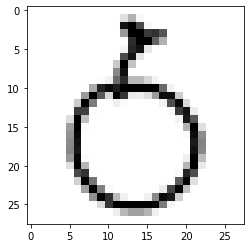

In [52]:
data = data / 255
data = np.reshape(data, (data.shape[0], 28,28,1))

img_w, img_h= data.shape[1:3]

plt.imshow(data[4241,:,:,0], cmap='Greys')
plt.show()

In [25]:
data_airplane = np.load('full_numpy_bitmap_airplane.npy') # 넘파이 .npy 포맷의 (친숙한) 28x28 흑백 비트맵. 이미지는 중앙에 맞춰져 있습니다.

In [27]:
data_airplane.shape


(151623, 784)

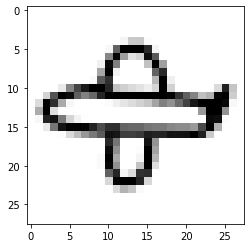

In [28]:
data_airplane = data_airplane / 255
data_airplane = np.reshape(data_airplane, (data_airplane.shape[0], 28,28,1))

img_w, img_h= data_airplane.shape[1:3]

plt.imshow(data_airplane[4241,:,:,0], cmap='Greys')
plt.show()

In [88]:
#create a discriminator network
def build_discriminator(depth=64, p=0.4):

    # 입력
    image = Input((img_w,img_h,1))
    
    # 합성곱 층
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # 출력층
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # 모델 생성
    model = Model(inputs=image, outputs=prediction)
    
    return model




In [89]:
discriminator = build_discriminator()

In [90]:
discriminator.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_33 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_34 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_35 (Dropout)         (None, 4, 4, 256)         0   

In [91]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, 
                                        decay=6e-8, 
                                        clipvalue=1.0), 
                      metrics=['accuracy'])


In [92]:
z_dimensions = 32

In [85]:
#create a generator network

def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # 입력
    noise = Input((latent_dim,))
    
    # 첫 번째 은닉층
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # 전치합성곱 층
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # 출력층
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # 모델 생성
    model = Model(inputs=noise, outputs=image)
    
    return model

In [93]:
generator = build_generator()

In [94]:
generator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 3136)              103488    
_________________________________________________________________
batch_normalization_20 (Batc (None, 3136)              12544     
_________________________________________________________________
activation_20 (Activation)   (None, 3136)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 14, 14, 64)        0   

In [95]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [96]:
discriminator.trainable = False

In [97]:
pred = discriminator(img)

In [98]:
adversarial_model = Model(z, pred)

In [99]:
adversarial_model.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0004, 
                                        decay=3e-8, 
                                        clipvalue=1.0), 
                      metrics=['accuracy'])

에포크 #99
99: [D 손실: 0.415957, acc: 0.856179]  [A 손실: 2.525478, acc: 0.108665]


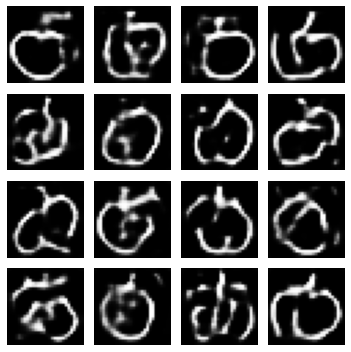

In [104]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
  d_metrics = []
  a_metrics = []

  running_d_loss = 0
  running_d_acc = 0
  running_a_loss = 0
  running_a_acc = 0

  for i in range(epochs):
    real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch, 28, 28, 1))
    fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dimensions]))

    x = np.concatenate((real_imgs, fake_imgs))

    y = np.ones([2*batch, 1])

    y[batch:,:] = 0

    d_metrics.append(discriminator.train_on_batch(x,y))

    running_d_loss += d_metrics[-1][0]
    running_d_acc += d_metrics[-1][1]

    noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])

    y = np.ones([batch, 1])

    a_metrics.append(adversarial_model.train_on_batch(noise, y))

    running_a_loss += a_metrics[-1][0]
    running_a_acc += a_metrics[-1][1]

    if(i+1)%100 == 0:
      print('에포크 #{}'.format(i))
      log_mesg = "%d: [D 손실: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
      log_mesg = "%s  [A 손실: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
      print(log_mesg)
      
      noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])  
      gen_imgs = generator.predict(noise)
      
      plt.figure(figsize=(5,5))

      for k in range(gen_imgs.shape[0]):
        plt.subplot(4,4,k+1)
        plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
        plt.axis('off')
      
      plt.tight_layout()
      plt.show()

      return a_metrics, d_metrics

a_metrics_complete, d_metrics_complete = train()


Text(0, 0.5, 'Loss')

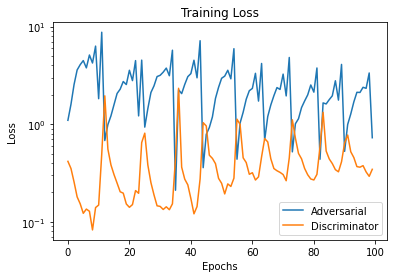

In [105]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

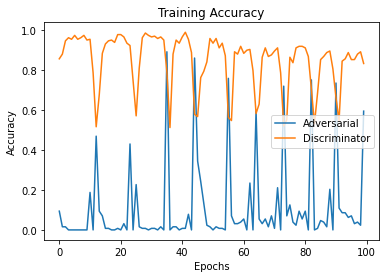

In [106]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")